In [2]:
import cv2
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
import re

In [3]:
# Labels and Classes
dataset_path = 'GTSRB_dataset'
labels_df = pd.read_csv('GTSRB_dataset/labels.csv')
print(labels_df)

    ClassId                          Name
0         0           Speed limit (5km/h)
1         1          Speed limit (15km/h)
2         2          Speed limit (30km/h)
3         3          Speed limit (40km/h)
4         4          Speed limit (50km/h)
5         5          Speed limit (60km/h)
6         6          Speed limit (70km/h)
7         7          speed limit (80km/h)
8         8      Dont Go straight or left
9         9     Dont Go straight or Right
10       10              Dont Go straight
11       11                  Dont Go Left
12       12         Dont Go Left or Right
13       13                 Dont Go Right
14       14       Dont overtake from Left
15       15                      No Uturn
16       16                        No Car
17       17                       No horn
18       18          Speed limit (40km/h)
19       19          Speed limit (50km/h)
20       20          Go straight or right
21       21                   Go straight
22       22                       

In [4]:
# Load Training Data
def load_data(data_dir):
    images, labels = [], []
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):  # Ensure we process only directories
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (32, 32))  # Resize to 32x32
                images.append(img)
                labels.append(int(label))  # Assuming folder names are labels
    return np.array(images), np.array(labels)

In [5]:
# Load Test Data with Labels
def load_test_data_with_labels(test_dir):
    images, labels = [], []
    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (32, 32))  # Resize to 32x32
        images.append(img)
        # Extract label from filename using regex or string splitting
        label_match = re.match(r'(\d+)_', img_file)
        if label_match:
            labels.append(int(label_match.group(1)))  # Extract numeric label
        else:
            raise ValueError(f"Could not parse label from filename: {img_file}")
    return np.array(images), np.array(labels)

In [6]:
# Load training and test data
data_path = './GTSRB_dataset/traffic_data/DATA'
test_path = './GTSRB_dataset/traffic_data/TEST'

X_train, y_train = load_data(data_path)
X_test, y_test = load_test_data_with_labels(test_path)

print(f"Training Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test Data: {X_test.shape}, Labels: {y_test.shape}")

Training Data: (4170, 32, 32, 3), Labels: (4170,)
Test Data: (1994, 32, 32, 3), Labels: (1994,)


In [7]:
# Normalize and one-hot encode labels
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
# Define CNN model
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = (32, 32, 3)  # Assuming RGB images resized to 32x32
num_classes = len(labels_df['ClassId'].unique())
model = build_model(input_shape, num_classes)
model.summary()

c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 58)             │         7,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,810 (1.23 MB)

 Trainable params: 322,362 (1.23 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)
datagen.fit(X_train)

In [11]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

In [12]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2086 - loss: 3.6368 - val_accuracy: 0.0492 - val_loss: 3.9514
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4997 - loss: 1.9190 - val_accuracy: 0.0600 - val_loss: 4.3374
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6061 - loss: 1.4411 - val_accuracy: 0.1523 - val_loss: 4.1211
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6573 - loss: 1.1770 - val_accuracy: 0.3118 - val_loss: 2.6969
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7104 - loss: 0.9910 - val_accuracy: 0.5204 - val_loss: 1.7109
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7514 - loss: 0.8511 - val_accuracy: 0.8393 - val_loss: 0.6362
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7806 - loss: 0.7397 - val_accuracy: 0.9149 - val_loss: 0.3341
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8073 - loss: 0.6457 - val_accuracy: 0.884

In [13]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6180 - loss: 1.5822
Test Accuracy: 0.66


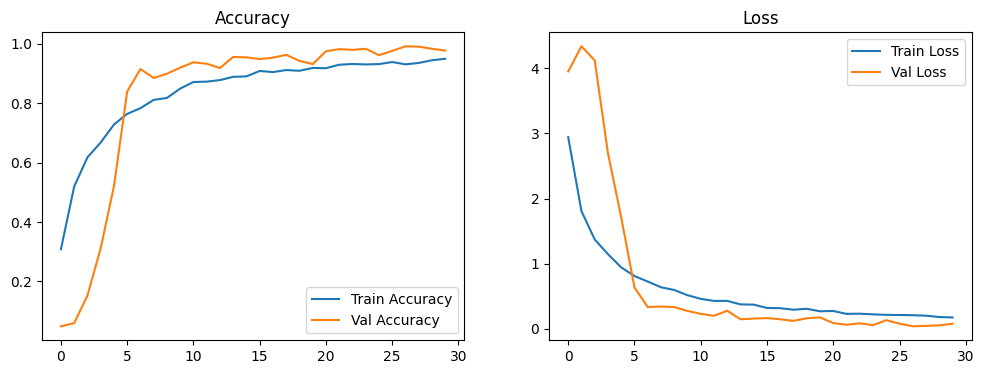

In [14]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


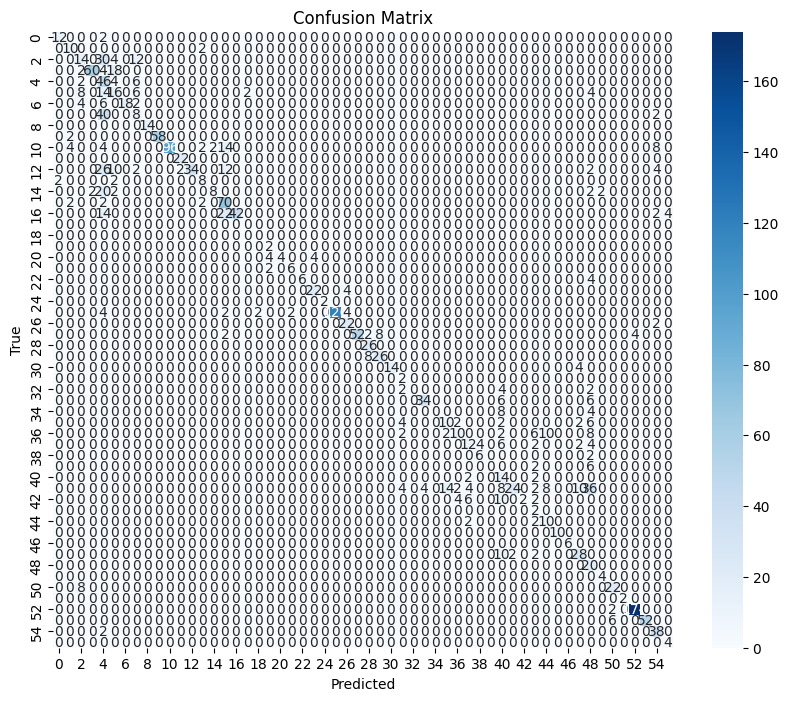

In [15]:
# Predictions and evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Classification Report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.56      0.83      0.67        12
           2       0.37      0.23      0.29        60
           3       0.97      0.71      0.82        84
           4       0.21      0.79      0.34        58
           5       0.29      0.32      0.30        50
           6       1.00      0.60      0.75        30
           7       0.22      0.16      0.19        50
           8       1.00      1.00      1.00        14
          10       1.00      0.97      0.98        60
          11       1.00      0.74      0.85       130
          12       0.92      1.00      0.96        22
          13       1.00      0.37      0.54        92
          14       0.57      0.67      0.62        12
          15       0.80      0.22      0.35        36
          16       0.57      0.92      0.71        76
          17       1.00      0.50      0.67        84
          18       0.00    

c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

-----------------------------Visualizations-----------------------------

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


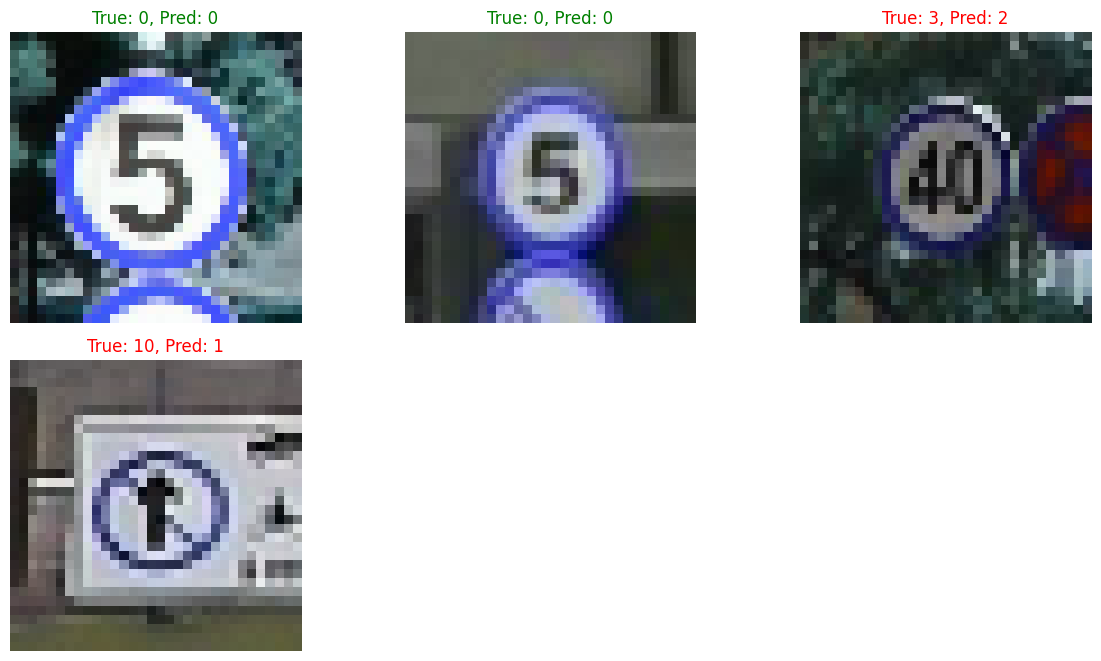

In [17]:
def visualize_classification(image_indices):
    plt.figure(figsize=(12, 10))
    for i, idx in enumerate(image_indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_test[idx])
        pred_class = y_pred_classes[idx]
        true_class = y_true[idx]
        color = 'green' if pred_class == true_class else 'red'
        plt.title(f"True: {true_class}, Pred: {pred_class}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Example: Select specific indices for visualization
example_indices = [10,12,90,400]
visualize_classification(example_indices)